In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# read the CSV file into a pandas dataframe
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


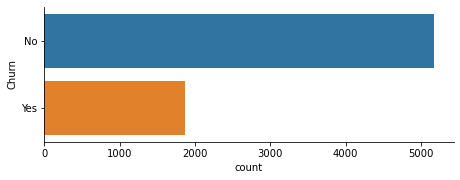

In [4]:
# Predicted variable
ax = sns.catplot(y="Churn", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

### 2. Numerical features
There are only three numerical columns: tenure, monthly charges and total charges. The probability density distribution can be estimate using the seaborn kdeplot function.

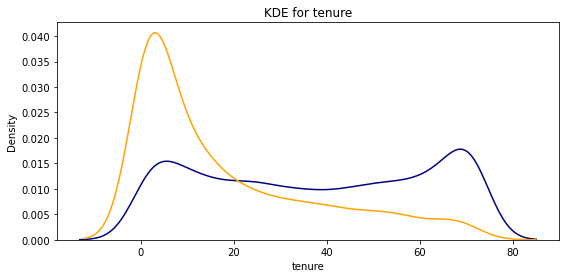

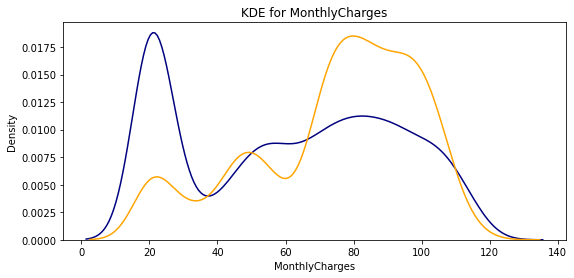

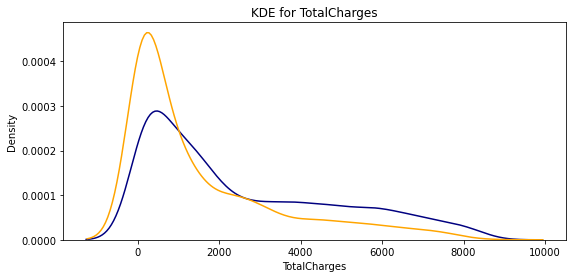

In [5]:
# Impute missing values
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

From the plots above we can conclude that:

- Recent clients are more likely to churn

- Clients with higher MonthlyCharges are also more likely to churn

- Tenure and MonthlyCharges are probably important features


### 3. Categorical features
This dataset has 16 categorical features:

- Six binary features (Yes/No)
- Nine features with three unique values each (categories)
- One feature with four unique values

### 3.1 Gender and Age (SeniorCitizen)

/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_26336/934766672.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


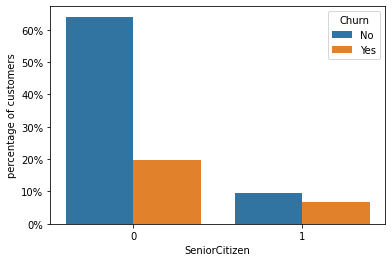

In [6]:
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df.groupby(feature)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

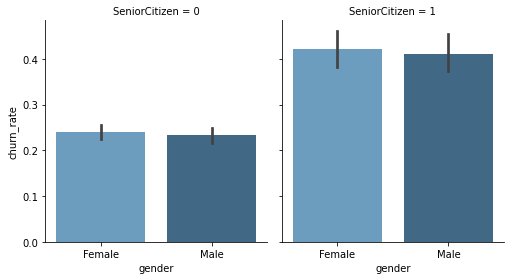

In [7]:
df['churn_rate'] = df['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "Blues_d", order= ['Female', 'Male'])

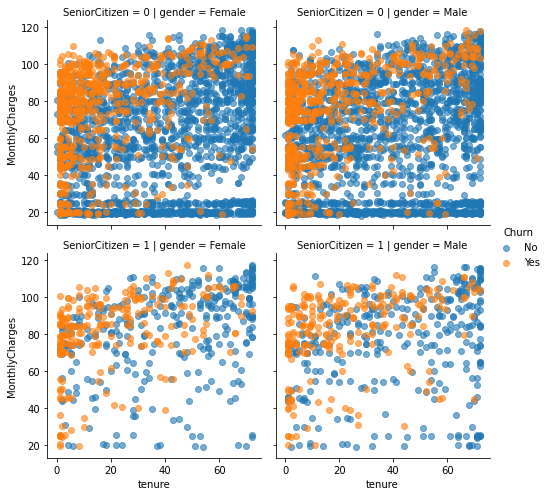

In [8]:
g = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn", height=3.5)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
g.add_legend();

Gender is not an indicative of churn.
- SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.
- There are no special relations between this categorical values and the main numerical features.

### 3.2 Partner and dependents

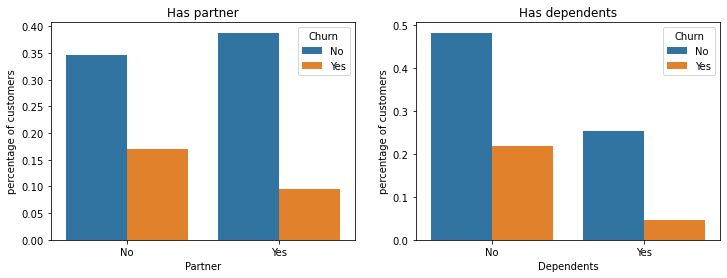

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

- Customers that doesn't have partners are more likely to churn
- Customers without dependents are also more likely to churn

### 3.3 Phone  services

/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_26336/934766672.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


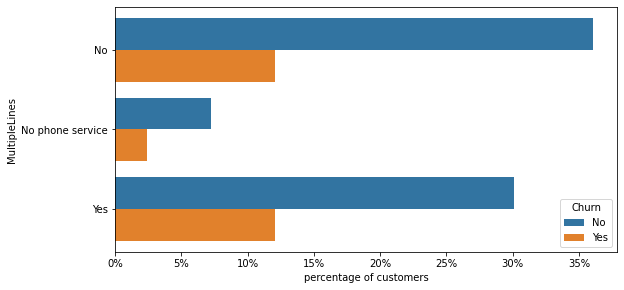

In [10]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("MultipleLines", orient='h')

### 3.4 Phone services

/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_26336/934766672.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


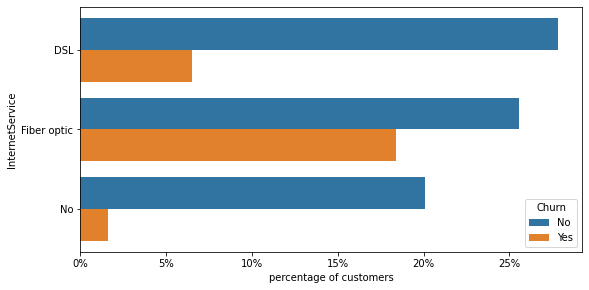

In [11]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

- Clients without internet have a very low churn rate
- Customers with fiber are more probable to churn than those with DSL connection
- Comparing the Internet service with monthly charges:

### 3.4 Additional internet services

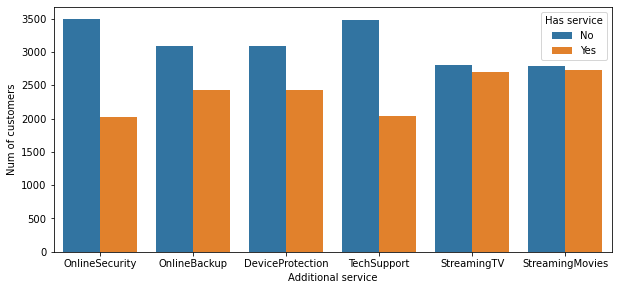

In [12]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

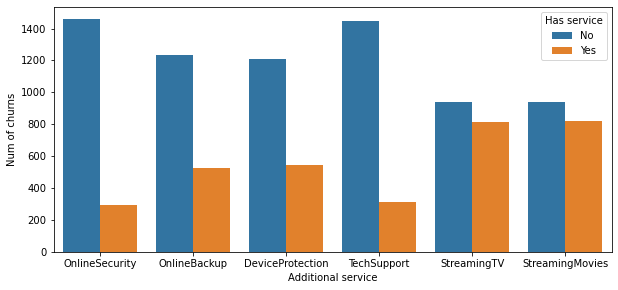

In [13]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

The first plot shows the total number of customers for each additional service, while the second shows the number of clients that churn. We can see that:

- Customers with the first 4 additionals (security to tech support) are more unlikely to churn
- Streaming service is not predictive for churn

### 3.5 Contract and Payment

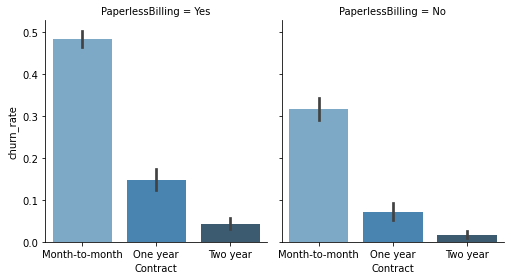

In [14]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])

/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_26336/934766672.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


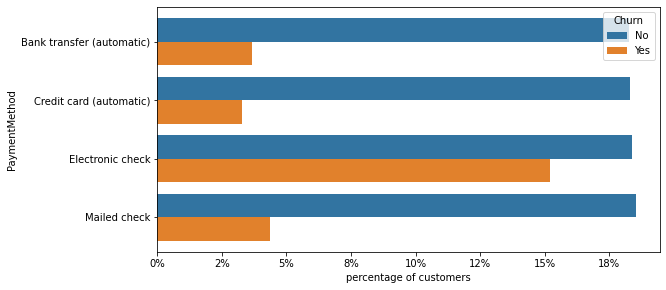

In [15]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='h')

A few observations:

- Customers with paperless billing are more probable to churn
- The preferred payment method is Electronic check with around 35% of customers. This method also has a very high churn rate
- Short term contracts have higher churn rates

One and two year contracts probably have contractual fines and therefore customers have to wait untill the end of contract to churn

### 4. Correlation between features

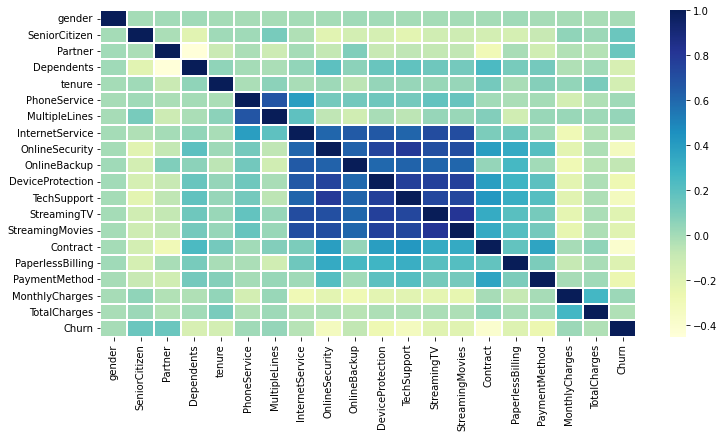

In [16]:
plt.figure(figsize=(12, 6))
df.drop(['customerID', 'churn_rate'],
        axis=1, inplace=True)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Encoding preprocesing

In [22]:
def encode_categorical(df):
    num_cols = []
    binary_cols = []
    multiple_cols = []

    encoding_dict = {}  # to store the label encoding mappings

    for col in df.columns:
        if df[col].dtype != 'object':
            num_cols.append(col)
        elif len(df[col].unique()) == 2:
            binary_cols.append(col)
        else:
            multiple_cols.append(col)
            # label encode the categories
            unique_categories = df[col].unique()
            encoding_dict[col] = {cat: i for i, cat in enumerate(unique_categories)}

    print("Numerical columns: ", num_cols)
    print("Binary category columns: ", binary_cols)
    print("Multiple categories columns: ", multiple_cols)

    # Initialize encoded_df before using it
    encoded_df = pd.DataFrame(index=df.index)

    # Standardize the numerical columns
    scaler = StandardScaler()
    num_data = scaler.fit_transform(df[num_cols])
    num_df = pd.DataFrame(num_data, columns=num_cols)
    encoded_df[num_cols] = num_df

    # Encode the binary columns
    encoded_df[binary_cols] = df[binary_cols].apply(lambda x: x.apply(lambda y: 1 if y == 'Yes' else 0))

    # Encode the multiple columns
    for col in multiple_cols:
        # use the label encoding mappings to transform the categories to integers
        encoded_df[col] = df[col].map(encoding_dict[col])

    return encoded_df, encoding_dict

In [23]:
encode_df, encoding_dict = encode_categorical(df)

 # print the label encoding mappings
for col, mapping in encoding_dict.items():
    print(f"{col}:")
    for label, value in mapping.items():
        print(f"  {label} -> {value}") 

Numerical columns:  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Binary category columns:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
Multiple categories columns:  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
MultipleLines:
  No phone service -> 0
  No -> 1
  Yes -> 2
InternetService:
  DSL -> 0
  Fiber optic -> 1
  No -> 2
OnlineSecurity:
  No -> 0
  Yes -> 1
  No internet service -> 2
OnlineBackup:
  Yes -> 0
  No -> 1
  No internet service -> 2
DeviceProtection:
  No -> 0
  Yes -> 1
  No internet service -> 2
TechSupport:
  No -> 0
  Yes -> 1
  No internet service -> 2
StreamingTV:
  No -> 0
  Yes -> 1
  No internet service -> 2
StreamingMovies:
  No -> 0
  Yes -> 1
  No internet service -> 2
Contract:
  Month-to-month -> 0
  One year -> 1
  Two year -> 2
PaymentMethod:
  Electronic check -> 0
  Mailed chec

In [24]:
encode_df.tail(10)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod
7033,-0.439916,0.229209,0.157482,0.152436,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,3
7034,-0.439916,1.410099,1.269224,2.032316,0,0,0,1,1,1,2,1,1,0,1,0,1,0,0,3
7035,-0.439916,-0.544478,0.463253,-0.346167,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0,2
7036,-0.439916,-0.829521,-0.136656,-0.677849,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
7037,-0.439916,1.613701,-1.449476,-0.379565,0,0,0,1,1,0,1,2,2,2,2,2,2,2,2,2
7038,-0.439916,-0.340876,0.665992,-0.127605,0,1,1,1,1,0,2,0,1,1,1,1,1,1,1,1
7039,-0.439916,1.613701,1.277533,2.242606,0,1,1,1,1,0,2,1,0,0,1,0,1,1,1,3
7040,-0.439916,-0.870241,-1.168632,-0.852932,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0
7041,2.273159,-1.155283,0.320338,-0.870513,0,1,0,1,1,1,2,1,0,1,0,0,0,0,0,1
7042,-0.439916,1.369379,1.358961,2.013897,0,0,0,1,1,0,1,1,1,1,1,1,1,1,2,2


## Split train/test

In [25]:
X = encode_df.drop(["Churn"], axis=1)
y = encode_df[["Churn"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 112)

### Standardization

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5. Feature Importance

/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_26336/3559030445.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train, y_train)


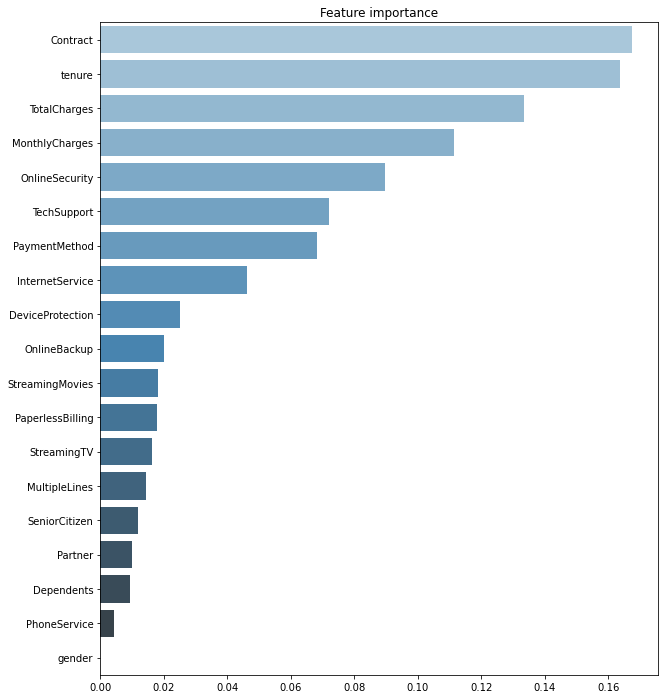

In [27]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(X_train, y_train)

# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

## Models compraison

### Classification: supervised

In [34]:
classifiers = [ ('KNN', KNeighborsClassifier()),
               ("SVC", SVC()),
               ("CART", DecisionTreeClassifier()),
               ("RF", RandomForestClassifier()),
               ('ExtraTrees', ExtraTreesClassifier()),
               ('Adaboost', AdaBoostClassifier()),
               ('GBM', GradientBoostingClassifier()),
               ('XGBoost', XGBClassifier(eval_metric='mlogloss',verbosity = 0)),
               ('LightGBM', LGBMClassifier()),
               ('CatBoost', CatBoostClassifier(verbose=False))
               ]

for name, classifier in classifiers:
    cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC: {round(cv_results['test_roc_auc'].mean(),4)} ({name}) ")


cart_params = {'max_depth': [8],
               "min_samples_split": [20]}


lightgbm_params = {"learning_rate": [0.01],
                   "n_estimators": [500],
                   "colsample_bytree": [0.7]}


rf_params = {"max_depth": [8],
             "max_features": ["auto"],
             "min_samples_split": [8],
             "n_estimators": [1000]}

gbm_params= {"learning_rate": [0.01],
            "max_depth": [5],
            "max_features": ["sqrt"],
            "n_estimators": [500]}


classifiers = [("CART", DecisionTreeClassifier(), cart_params),
               ("LightGBM", LGBMClassifier(), lightgbm_params),
               ("GBM", GradientBoostingClassifier(), gbm_params) ]


best_models = {}
for name, classifier, params in classifiers:
    print(f"########## {name} ##########")
    cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC (Before): {round(cv_results['test_roc_auc'].mean(),4)}")


    gs_best = GridSearchCV(classifier, params, cv=5, verbose=False).fit(X_train,  y_train.values.ravel())
    final_model = classifier.set_params(**gs_best.best_params_)

    cv_results = cross_validate(final_model, X_train,  y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC (After): {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


best_models
encode_df.head()

feature_imp_all = pd.DataFrame({'Model': np.NaN,
                                'AUC_Score': np.NaN,
                                'Feature': np.NaN,
                                'Value': np.NaN,
                                'Weighted_Score': np.NaN}, index=[0])

for model, classifier in best_models.items():
    final_model = classifier.fit(X_train, y_train.values.ravel())
    cv_results = cross_validate(final_model, X_train, y_train, cv=5, scoring=["roc_auc"])
    score_final = round(cv_results['test_roc_auc'].mean(), 4)
    # rmse_final = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

    feature_imp = pd.DataFrame({'Model': model,
                                'AUC_Score': score_final * 100,
                                'Feature': X_train.columns,
                                'Value': final_model.feature_importances_,
                                'Weighted_Score': score_final * 100 * final_model.feature_importances_})

    feature_imp_all = pd.concat([feature_imp_all, feature_imp], axis=0)
    feature_imp_all.dropna(inplace=True)


#feature_imp_all.sort_values("Weighted_Score", ascending=False).head(20)
feature_imp_all.sort_values("AUC_Score", ascending=False).head(20)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

AUC: 0.7785 (KNN) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC: 0.8018 (SVC) 
AUC: 0.6486 (CART) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

AUC: 0.8219 (RF) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

AUC: 0.7992 (ExtraTrees) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC: 0.8444 (Adaboost) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC: 0.8474 (GBM) 
AUC: 0.8185 (XGBoost) 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC: 0.8294 (LightGBM) 
AUC: 0.8396 (CatBoost) 
########## CART ##########
AUC (Before): 0.6525
AUC (After): 0.7968
CART best params: {'max_depth': 8, 'min_samples_split': 20}

########## LightGBM ##########


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC (Before): 0.8294


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC (After): 0.8412
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

########## GBM ##########


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC (Before): 0.8473


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

AUC (After): 0.8485
GBM best params: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

,Model,AUC_Score,Feature,Value,Weighted_Score
18,GBM,84.87,PaymentMethod,0.079189,6.720803
9,GBM,84.87,MultipleLines,0.012280,1.042226
0,GBM,84.87,SeniorCitizen,0.010850,0.920836
1,GBM,84.87,tenure,0.165848,14.075487
2,GBM,84.87,MonthlyCharges,0.110405,9.370059
3,GBM,84.87,TotalCharges,0.118932,10.093793
4,GBM,84.87,gender,0.000000,0.000000
6,GBM,84.87,Dependents,0.006167,0.523388
7,GBM,84.87,PhoneService,0.004118,0.349491
8,GBM,84.87,PaperlessBilling,0.021011,1.783192


### Cluestering: unsupervised

In [36]:
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, SpectralClustering, DBSCAN, MeanShift, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score

# Define a list of classifiers with their parameters
classifiers = [('KMeans', KMeans()),
               ('MiniBatchKMeans', MiniBatchKMeans()),
               ('BIRCH', Birch()),
               ('SpectralClustering', SpectralClustering()),
               ('DBSCAN', DBSCAN()),
               ('MeanShift', MeanShift()),
               ('OPTICS', OPTICS()),
               ('GMM', GaussianMixture())]

'''for name, classifier in classifiers:
    cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC: {round(cv_results['test_roc_auc'].mean(),4)} ({name}) ")
'''
for name, classifier in classifiers:
    cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=["silhouette_score"])
    print(f"Silhouette Score: {round(cv_results['test_score'].mean(),4)} ({name}) ")

    
# Define the hyperparameters for grid search
kmeans_params = {"n_clusters": [3, 4, 5, 6, 7,8,9],
                 "init": ["k-means++", "random"],
                 "n_init": [10, 25, 50, 100],
                 "max_iter": [100, 250, 500, 1000],
                 "algorithm": ["full", "elkan"]}

birch_params = {"threshold": [0.1, 0.25, 0.5, 0.75],
                "branching_factor": [25, 50, 75, 100]}

dbscan_params = {"eps": [0.25, 0.5, 0.75, 1.0],
                 "min_samples": [2, 3, 4, 5]}

spectral_params = {"n_clusters": [2, 3, 4, 5, 6, 7, 8, 9],
                   "eigen_solver": ["arpack", "lobpcg", "amg"],
                   "n_init": [10, 25, 50, 100],
                   "gamma": [0.1, 1.0, 10.0],
                   "affinity": ["nearest_neighbors", "rbf"]}

gmm_params = {"n_components": [2,3,4,5,6],
              "covariance_type": ["full", "tied", "diag", "spherical"],
              "max_iter": [100, 250, 500, 1000]}

# Define a list of classifiers with their hyperparameters for grid search
classifiers = [("KMeans", KMeans(), kmeans_params),
               ("MiniBatchKMeans", MiniBatchKMeans(), kmeans_params),
               ("BIRCH", Birch(), birch_params),
               ("DBSCAN", DBSCAN(), dbscan_params),
               ("SpectralClustering", SpectralClustering(), spectral_params),
               ("GMM", GaussianMixture(), gmm_params)]

# Fit each classifier using grid search and evaluate using 5-fold cross-validation
best_models = {}

# Train the best model for each classifier using grid search and evaluate on the testing data
for name, classifier, params in classifiers:
    print(f"########## {name} ##########")
    
    # Evaluate the AUC score before hyperparameter tuning
    cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC (Before): {round(cv_results['test_roc_auc'].mean(),4)}")

    # Perform grid search to find the best hyperparameters
    gs_best = GridSearchCV(classifier, params, cv=5, verbose=False).fit(X_train, y_train)
    final_model = classifier.set_params(**gs_best.best_params_)

    # Evaluate the AUC score after hyperparameter tuning
    cv_results = cross_validate(final_model, X_train, y_train, cv=5, scoring=["roc_auc"])
    print(f"AUC (After): {round(cv_results['test_roc_auc'].mean(),4)}")

    # Fit the best model on the training data and evaluate on the testing data
    best_models[name] = final_model.fit(X_train, y_train)
    y_pred = best_models[name].predict(X_test)
    print(f"Test AUC: {round(roc_auc_score(y_test, y_pred),4)}\n")

# Print the best model and its performance on the testing data for each classifier
print("Best Models:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Test AUC: {round(roc_auc_score(y_test, y_pred),4)}")


ValueError: 'silhouette_score' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.